In [1]:
from pathlib import Path
import re
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import math
from scipy.interpolate import RegularGridInterpolator

In [2]:
plt.style.use(["science", "notebook", "grid"])

In [3]:
def plot_complex_matrix(
    matrix,
    title="OP matrix",
    interpolation="none",
    vmin=-1.0,
    vmax=1.0,
    log_scale=False,
):
    """
    Plots a matrix. If the matrix is complex, plots both the real and imaginary parts.
    If the matrix is real, plots only the real part.

    Args:
        matrix (np.ndarray): Matrix to plot.
        log_scale (bool): Whether to use log scale for color mapping. Default is False.
    """
    if not isinstance(matrix, np.ndarray):
        raise TypeError("Input must be a NumPy array.")

    def get_plot_data(data):
        if log_scale:
            # Add a small epsilon to avoid log(0)
            epsilon = 1e-12
            return np.log10(np.abs(data) + epsilon)
        else:
            return data

    if np.iscomplexobj(matrix):
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        im0 = axs[0].imshow(
            get_plot_data(matrix.real),
            cmap="RdBu",
            interpolation=interpolation,
            vmin=vmin,
            vmax=vmax,
        )
        plt.colorbar(im0, ax=axs[0])
        axs[0].set_title(f"Re of {title}" + (" (log scale)" if log_scale else ""))

        im1 = axs[1].imshow(
            get_plot_data(matrix.imag),
            cmap="BrBG",
            interpolation=interpolation,
            vmin=vmin,
            vmax=vmax,
        )
        plt.colorbar(im1, ax=axs[1])
        axs[1].set_title(f"Im of {title}" + (" (log scale)" if log_scale else ""))

        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 8))
        plt.imshow(
            get_plot_data(matrix),
            cmap="RdBu",
            interpolation=interpolation,
            vmin=vmin,
            vmax=vmax,
        )
        plt.colorbar()
        plt.title(f"Re of {title}" + (" (log scale)" if log_scale else ""))
        plt.tight_layout()
        plt.show()


def get_V_coords(L):
    V = np.zeros((L, L, 2))
    for k_1 in range(L):
        for k_2 in range(L):
            V[k_1, k_2] = np.array([k_1 / L, k_2 / L])
    return V


def scatter_plot(matrix, title="Real Part of OP"):
    # input should be of shape (L, L, 2, 2)
    L = matrix.shape[0]
    V = get_V_coords(L)
    X = V[:, :, 1]
    Y = V[:, :, 0]

    figure, axes = plt.subplots(2, 2, figsize=(12, 12))

    scatter = None

    for i in range(2):
        for j in range(2):
            ax = axes[i, j]
            ax.set_title(f"({i + 1}, {j + 1})")
            scatter = ax.scatter(
                X, Y, c=matrix[:, :, i, j], cmap="plasma", vmin=-1.0, vmax=1.0
            )
            ax.set_aspect("equal")
            ax.set_facecolor("w")

    # general settings for the whole figure
    figure.tight_layout(
        rect=[0, 0, 0.9, 1]
    )  # Adjust layout to make space for the colorbar
    figure.suptitle(title, y=1.03, fontsize=25)

    # --- New: Create a single colorbar for the entire figure ---
    # Create a new axes for the colorbar on the right side of the figure
    cbar_ax = figure.add_axes([0.92, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
    figure.colorbar(scatter, cax=cbar_ax)

    # Show plot
    plt.show()


def fold_OP_mat(OP_mat):
    # input should be of shape (2L^2, 2L^2)
    L = int(round(math.sqrt(OP_mat.shape[0] / 2)))
    # print(f"L is {L}")

    # fold the alpha's (2x2 matrices)
    folded_OP = np.zeros((L**2, L**2, 2, 2))
    real_part = OP_mat.real

    for k_1 in range(L):
        for k_2 in range(L):
            for k_1_prime in range(L):
                for k_2_prime in range(L):
                    row_idx = (2 * k_1 * L) + (2 * k_2)
                    col_idx = (2 * k_1_prime * L) + (2 * k_2_prime)
                    alpha_matrix = real_part[
                        row_idx : row_idx + 2, col_idx : col_idx + 2
                    ]
                    i = k_1 * L + k_2
                    j = k_1_prime * L + k_2_prime
                    folded_OP[i, j, :, :] = alpha_matrix

    # return the result
    return folded_OP


def unfold_OP_mat(folded_OP_mat):
    # input of shape (L^2, L^2, 2, 2)
    L = int(round(math.sqrt(folded_OP_mat.shape[0])))
    # print(f"L is {L}")

    OP_mat = np.zeros((2 * (L**2), 2 * (L**2)), dtype=np.complex128)

    for k_1 in range(L):
        for k_2 in range(L):
            for k_1_prime in range(L):
                for k_2_prime in range(L):
                    alpha_matrix = folded_OP_mat[
                        k_1 * L + k_2, k_1_prime * L + k_2_prime, :, :
                    ]
                    for i in range(2):
                        for j in range(2):
                            alpha_1 = i
                            alpha_2 = j
                            row_idx = (2 * k_1 * L) + (2 * k_2) + alpha_1
                            col_idx = (2 * k_1_prime * L) + (2 * k_2_prime) + alpha_2
                            OP_mat[row_idx, col_idx] = alpha_matrix[i, j] + (1j * 0)

    # return the result
    return OP_mat


def get_diagonal_line(folded_OP_mat, relation):
    # folded_OP_mat should be of shape (L^2, L^2, 2, 2)
    L = int(round(math.sqrt(folded_OP_mat.shape[0])))
    diagonal_matrix = np.zeros((L, L, 2, 2))

    # loop over OP
    for v_1_L in range(L):
        for v_2_L in range(L):
            v_1 = v_1_L / L
            v_2 = v_2_L / L
            v_1_prime = relation(v_1)
            v_2_prime = relation(v_2)

            v_1_prime_L = int(round(v_1_prime * L))
            v_2_prime_L = int(round(v_2_prime * L))

            # get row and column indices
            row_idx = (v_1_L * L) + v_2_L
            col_idx = (v_1_prime_L * L) + v_2_prime_L

            # fill in the diagonal matrix
            diagonal_matrix[v_1_L, v_2_L, :, :] = folded_OP_mat[row_idx, col_idx, :, :]

    return diagonal_matrix


def reformat_diagonal(diagonal_matrix, relation):
    # diagonal_matrix should be of shape (L, L, 2, 2)
    L = diagonal_matrix.shape[0]
    folded_OP_mat = np.zeros((L**2, L**2, 2, 2))

    # loop over the diagonal matrix
    for v_1_L in range(L):
        for v_2_L in range(L):
            v_1 = v_1_L / L
            v_2 = v_2_L / L
            v_1_prime = relation(v_1)
            v_2_prime = relation(v_2)

            v_1_prime_L = int(round(v_1_prime * L))
            v_2_prime_L = int(round(v_2_prime * L))

            # get row and column indices
            row_idx = (v_1_L * L) + v_2_L
            col_idx = (v_1_prime_L * L) + v_2_prime_L

            # fill in the folded OP matrix
            folded_OP_mat[row_idx, col_idx, :, :] = diagonal_matrix[v_1_L, v_2_L, :, :]

    return folded_OP_mat


def extract_diagonals(folded_OP_mat):
    return (
        get_diagonal_line(folded_OP_mat, relation=lambda v: v),
        get_diagonal_line(folded_OP_mat, relation=lambda v: (v + 0.5) % 1),
    )


def reformat_matrix_from_diagonals(diagonal_matrices):
    folded_OP_mat = reformat_diagonal(diagonal_matrices[0], relation=lambda v: v)
    folded_OP_mat += reformat_diagonal(
        diagonal_matrices[1], relation=lambda v: (v + 0.5) % 1
    )
    return folded_OP_mat


def get_interpolated_matrix(OP_mat, L_target: int = 18, method: str = "pchip"):
    # OP_mat should be of shape (2L^2, 2L^2)
    folded_OP_mat = fold_OP_mat(OP_mat)
    diag_list = extract_diagonals(folded_OP_mat)
    L = diag_list[0].shape[0]

    V_LxL = get_V_coords(L_target)

    test_list = []

    for diagonal_matrix in diag_list:
        diagonal_piece = np.zeros((L + 1, L + 1, 2, 2))
        diagonal_piece[:L, :L, :, :] = diagonal_matrix
        diagonal_piece[L, :L, :, :] = diagonal_matrix[0, :, :, :]
        diagonal_piece[:L, L, :, :] = diagonal_matrix[:, 0, :, :]
        v_L = np.array([i / L for i in range(L + 1)])

        interpolated_piece = np.zeros((L_target, L_target, 2, 2))
        for j in range(2):
            interpolator = RegularGridInterpolator(
                (v_L, v_L),
                diagonal_piece[:, :, j, j],
                method=method,
                bounds_error=False,
                fill_value=None,
            )
            pred = interpolator(V_LxL)
            interpolated_piece[:, :, j, j] = pred

        test_list.append(interpolated_piece)

    test_list = tuple(test_list)
    test_OP = reformat_matrix_from_diagonals(test_list)
    test_OP = unfold_OP_mat(test_OP)
    return test_OP

### Data Preprocessing

In [4]:
# state variables
U=2
error_c='2e-5'
label = f"U_{U}_ground_state"

In [5]:
def get_best_OP_mat(L: int, base_dir = f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/{label}/train_{error_c}"):
    pattern = re.compile(rf"^L_{L}_U_{U}_number_of_random_initials_(\d+)_occupied_{int(((L ** 2) / 2))}_{int(((L ** 2) / 2))}__index_(\d+)_new$")

    base_dir = Path(base_dir)

    # get the OP with the lowest energy
    min_energy = float("inf")
    best_OP = None

    # iterate over all the folders
    for folder in base_dir.iterdir():
        if folder.is_dir() and pattern.match(folder.name):
            results_filename = folder / "P_HF_result.h5"
            with h5py.File(results_filename, 'r') as results_file:
                num_samples = sum(1 for k in results_file.keys() if k.startswith("P_HF_result_"))
                for i in range(1, num_samples + 1):
                    try:
                        energy = (
                            results_file[f"HF_energy_per_unit_cell_{i}"][()].item().real
                        )
                        if energy < min_energy:
                            min_energy = energy
                            best_OP = np.transpose(
                                results_file[f"P_HF_result_{i}"][()]
                            ).conj()
                    except KeyError:
                        continue

    print(f"Minimum Energy: {min_energy}")
    return best_OP

In [6]:
def get_matching_OP(L: int, pattern_representative: np.ndarray, base_dir = f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/{label}/train_{error_c}"):
    pattern = re.compile(rf"^L_{L}_U_{U}_number_of_random_initials_(\d+)_occupied_{int(((L ** 2) / 2))}_{int(((L ** 2) / 2))}__index_(\d+)_new$")
    
    base_dir = Path(base_dir)

    # get the OP with the lowest energy
    min_energy = float("inf")

    # pattern representative should be of shape (2L_rep^2, 2L_rep^2)
    L_rep = int(round(math.sqrt(pattern_representative.shape[0] / 2)))

    # find the lowest energy
    min_energy = float("inf")
    reference_OP = None
    for folder in base_dir.iterdir():
        if folder.is_dir() and pattern.match(folder.name):
            results_filename = folder / "P_HF_result.h5"
            with h5py.File(results_filename, 'r') as results_file:
                num_samples = sum(1 for k in results_file.keys() if k.startswith("P_HF_result_"))
                for i in range(1, num_samples + 1):
                    try:
                        # find the energy
                        energy = (
                            results_file[f"HF_energy_per_unit_cell_{i}"][()].item().real
                        )
                    except KeyError:
                        continue

                    if energy - min_energy < 1e-4:
                        # get the OP for this initial
                        results_OP = np.transpose(
                            results_file[f"P_HF_result_{i}"][()]
                        ).conj()

                        # check interpolation
                        test_OP = get_interpolated_matrix(results_OP, L_rep)
                        max_abs = np.max(np.abs(test_OP - pattern_representative))
                        if max_abs < 0.5:  # means it has the same pattern
                            reference_OP = results_OP

                        if energy < min_energy:
                            min_energy = energy

    print(f"Minimum Energy: {min_energy}")
    return reference_OP

Minimum Energy: -0.3984206985135668
Minimum Energy: -0.39850439045927033
Minimum Energy: -0.2351886865676585


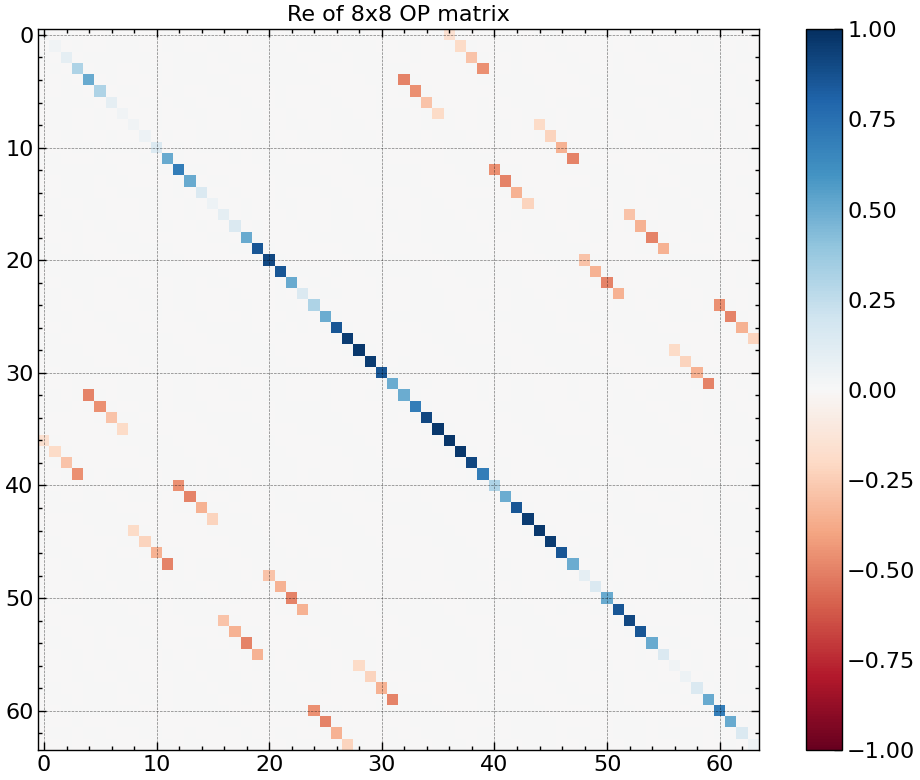

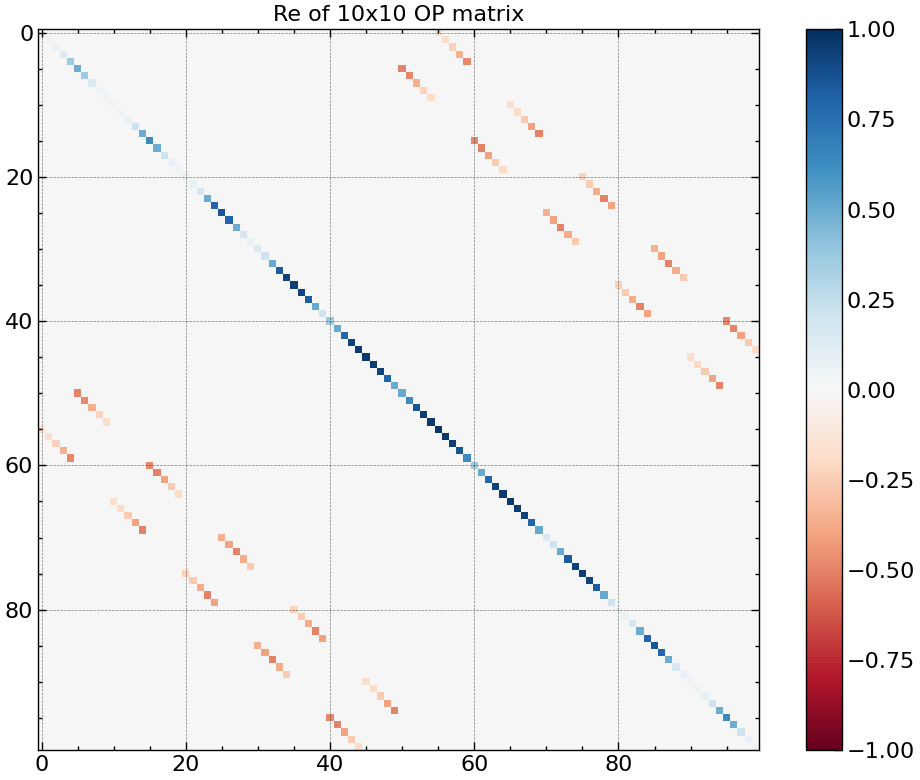

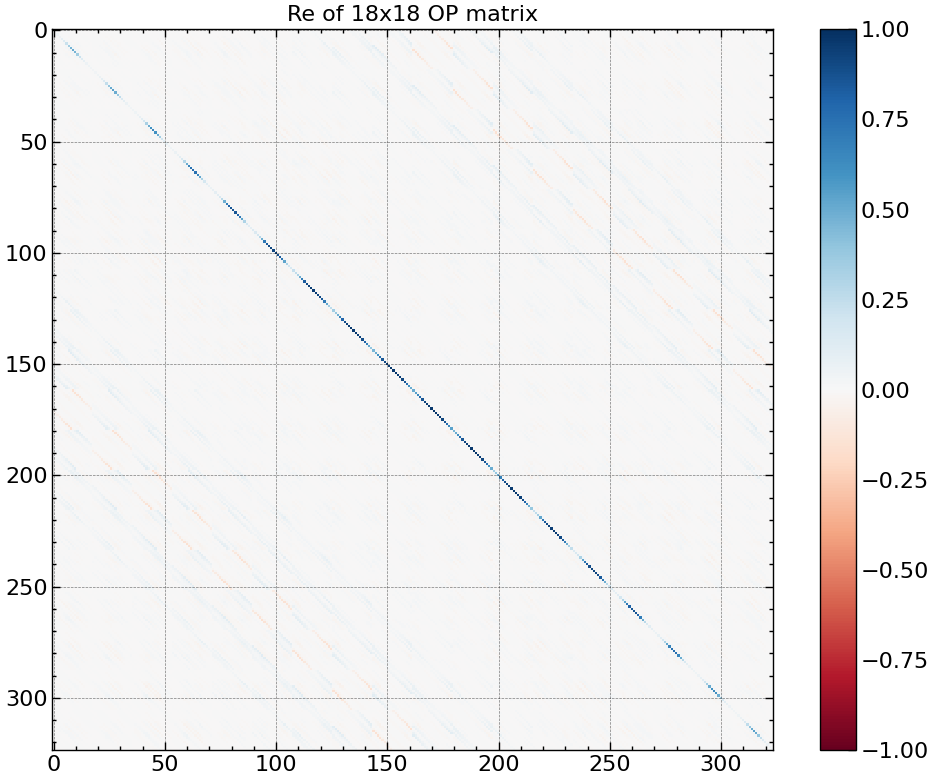

In [7]:
OP_8x8 = get_best_OP_mat(L=8)
OP_10x10 = get_matching_OP(10, OP_8x8)
OP_18x18 = get_matching_OP(18, OP_8x8)
plot_complex_matrix(fold_OP_mat(OP_8x8)[:, :, 1, 1], title="8x8 OP matrix")
plot_complex_matrix(fold_OP_mat(OP_10x10)[:, :, 1, 1], title="10x10 OP matrix")
plot_complex_matrix(fold_OP_mat(OP_18x18)[:, :, 1, 1], title="18x18 OP matrix")

In [8]:
with h5py.File(f"/blue/yujiabin/awwab.azam/hartree-fock-code/Julia_Hubbard_model_tunable_interaction_range_HF_For_ML_Trans_Breaking/{label}/train_{error_c}/{label}.h5", 'w') as f:
    f.create_dataset("OP_8x8", data=OP_8x8)
    f.create_dataset("OP_10x10", data=OP_10x10)
    f.create_dataset("OP_18x18", data=OP_18x18)